In [1]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
samples = 2428
seed = 244828
time_multiplicator = 1

In [3]:
def normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))

def standarize(matrix):
    return (matrix - np.mean(matrix))/(np.std(matrix))

In [4]:
def visualization(my,X_trN, X_tr, X_te, y_tr, y_te,epochs,learning_rate, name, threeD=True):
    if threeD:
        fig, axs = plt.subplots(3, 1,figsize=(10,24))
    else:
        fig, axs = plt.subplots(2, 1,figsize=(10,24))
    
    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.use(mse, mse_prime)
        my.fit(X_trN,y_tr, epochs, learning_rate)
    
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    my_pred = my.predict(X_te)
    my_pred = np.round(my_pred).reshape(X_test.shape[0])
    
    minv = np.min(X_tr)+np.min(X_tr)/10
    maxv = np.max(X_tr)+np.max(X_tr)/10
    mesh = np.meshgrid(np.arange(minv, maxv, 0.1), np.arange(minv, maxv, 0.1))[0]
    
    if threeD:
        my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
        axs[2].set_title(name)
        axs[2].contourf(mesh, mesh.T, my_predict, alpha=0.2)
        axs[2].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
        axs[2].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    else:
        pass
    
    
    my_cm = metrics.confusion_matrix(y_test, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[0])
    my_disp.ax_.set_ylabel('')
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  np.round(net.predict(X_te)).reshape(X_te.shape[0]))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=axs[1])

    
    my_sens = my_cm[0][0]/(my_cm[0][0]+my_cm[1][0])
    my_spec = my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])
    my_acc = metrics.accuracy_score(my_pred, y_test)
    my_bAcc = metrics.balanced_accuracy_score(my_pred, y_test)
    
    print(f'                  | {name}  ')
    print(f'Czułość           |{my_sens:9.4f}')
    print(f'Swoistość         |{my_spec:9.4f}')
    print(f'Accuracy          |{my_acc:9.4f}')
    print(f'bAccuracy         |{my_bAcc:9.4f}')
    print(f'Czas wykonania    |{my_time:9.2E}')

In [5]:
# Podstawowa klasa warstyw
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward_propagation(self, input):
        raise NotImplementedError
        
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [6]:
class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

# zwraca wyjscia dla danego inputa    
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

# obliczaeie pochodnych dla output_error zwraca input_error 
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [7]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self):
        self.activation = self.logisticAct
        self.activation_prime = self.logisticDer
    
    def logisticAct(self, X):
        return 1 / (1 + np.exp(-X))

    def logisticDer(self, X):
        return self.logisticAct(X) * (1-self.logisticAct(X))

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [8]:
# lossFunction
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [9]:
class Network:
    def __init__(self,batch=8):
        self.batch_size = batch 
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.errors = []

# dodawanie warstwy
    def add(self, layer):
        self.layers.append(layer)

# wykorzystywanie funkcji straty
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

# przewidywanie
    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result
    
# uczenie
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = x_train.shape[0]
        batch_divisible = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        
        for i in range(epochs):
            err = 0
            
            x_train, y_train = shuffle(x_train, y_train, random_state=0)
            
            for i in range(int(np.floor(samples/self.batch_size))):
                x_train_new = x_train[0+i*self.batch_size : self.batch_size+i*self.batch_size]
                y_train_new = y_train[0+i*self.batch_size : self.batch_size+i*self.batch_size]
                
                for j in range(self.batch_size):
                    output = x_train_new[j]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train_new[j], output)


                    error = self.loss_prime(y_train_new[j], output)
                    for layer in reversed(self.layers):
                        error = layer.backward_propagation(error, learning_rate)


            self.errors.append(err / samples)

                  | 2-warstwy, 2-węzły  
Czułość           |   0.9960
Swoistość         |   0.9872
Accuracy          |   0.9918
bAccuracy         |   0.9916
Czas wykonania    | 1.26E+01


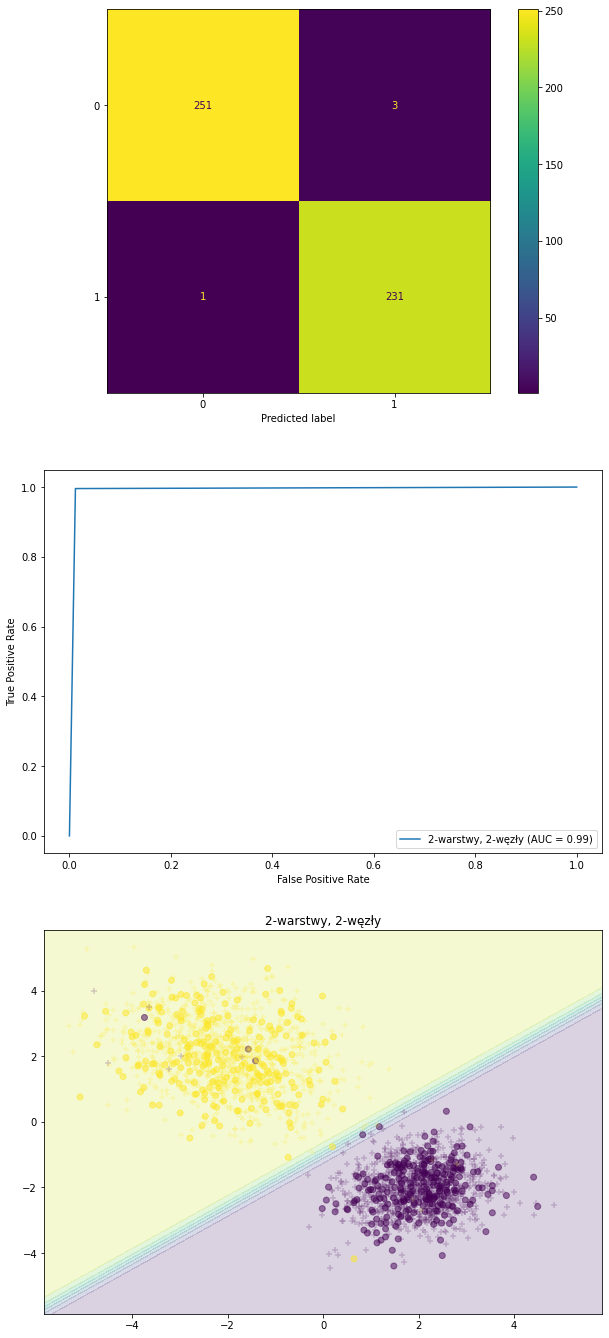

In [10]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network(100)
net.add(FCLayer(2, 2))
net.add(ActivationLayer())
net.add(FCLayer(2, 1))
net.add(ActivationLayer())

X_train_new = X_train.reshape(X_train.shape[0],1,2)

visualization(net ,X_train_new,X_train, X_test, y_train, y_test,100,0.1, name = '2-warstwy, 2-węzły')

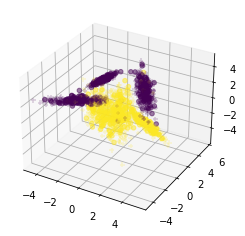

                  | 3-warstwy, 16-węzły  
Czułość           |   0.9961
Swoistość         |   0.9956
Accuracy          |   0.9959
bAccuracy         |   0.9959
Czas wykonania    | 1.78E+01


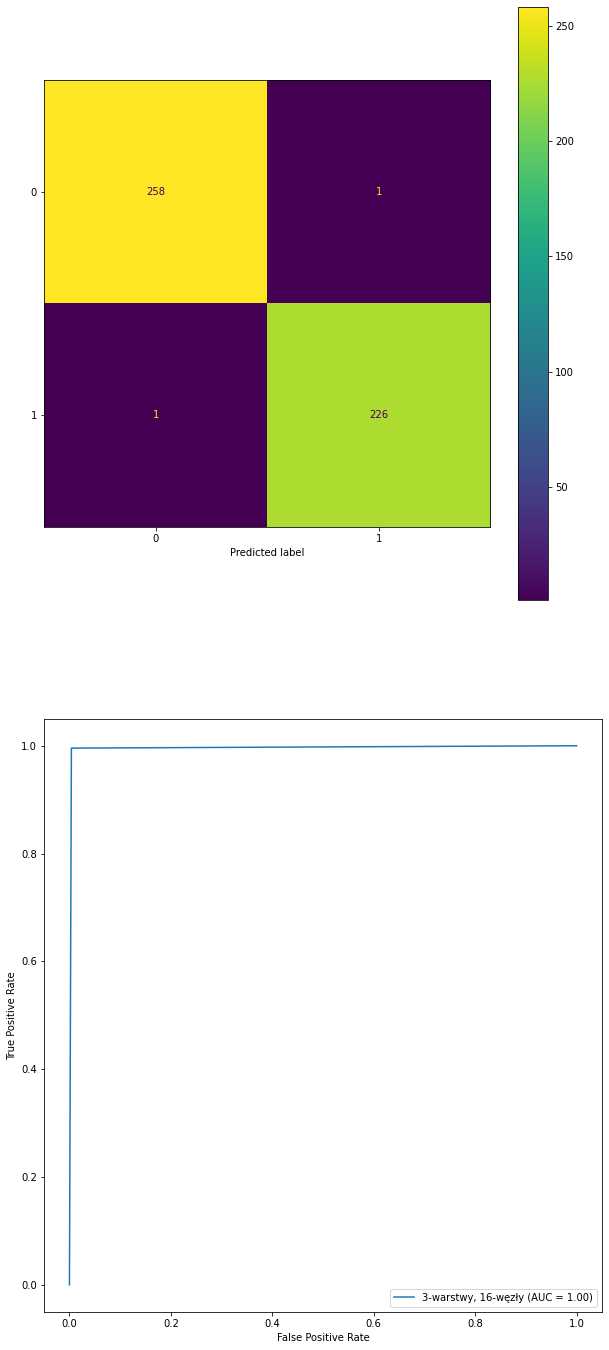

In [11]:
X, y  = datasets.make_classification(n_features=3, n_clusters_per_class=3, n_redundant=0, n_informative=3,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ax = plt.axes(projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1],X_test[:, 2], c=y_test, marker="o", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1],X_train[:, 2], c=y_train, marker="+", alpha=0.2)
plt.show()

net = Network(100)
net.add(FCLayer(3, 16))
net.add(ActivationLayer())
net.add(FCLayer(16, 16))
net.add(ActivationLayer())
net.add(FCLayer(16, 1))
net.add(ActivationLayer())

X_train_new = X_train.reshape(X_train.shape[0],1,3)

visualization(net ,X_train_new,X_train, X_test, y_train, y_test,100,0.1, name = '3-warstwy, 16-węzły', threeD = False)

                  | 3-warstwy, 8-węzłów  
Czułość           |   0.9553
Swoistość         |   0.9917
Accuracy          |   0.9733
bAccuracy         |   0.9735
Czas wykonania    | 1.74E+01


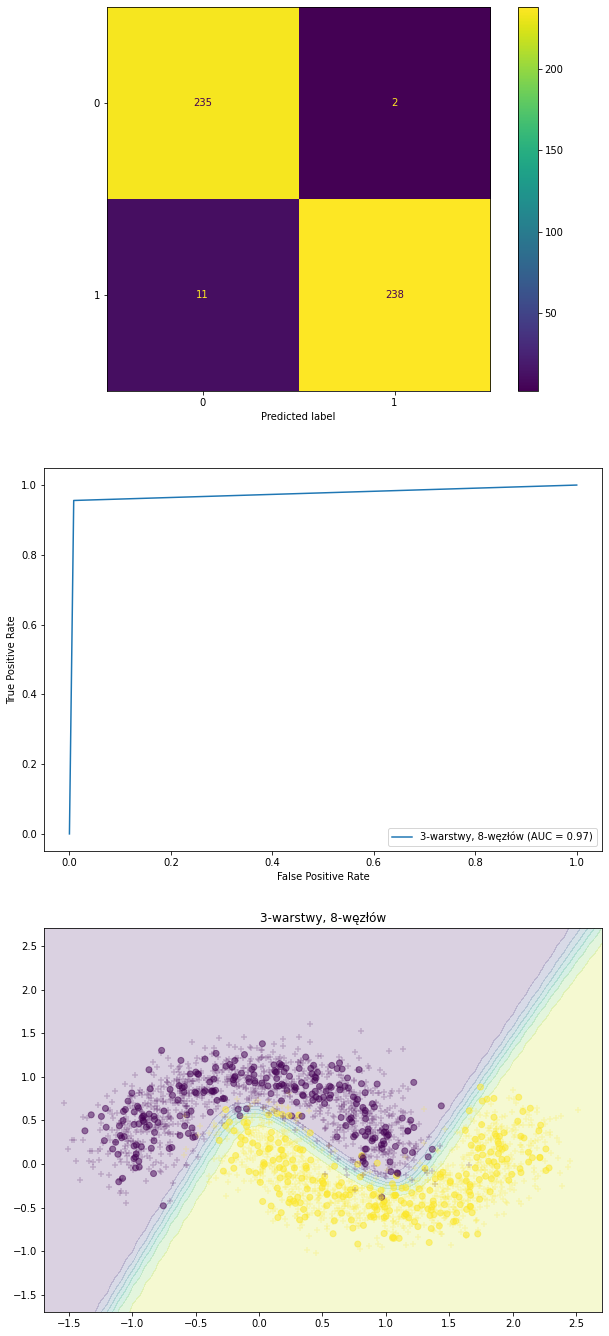

In [12]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.2, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

net = Network(100)
net.add(FCLayer(2, 8))
net.add(ActivationLayer())
net.add(FCLayer(8, 8))
net.add(ActivationLayer())
net.add(FCLayer(8, 1))
net.add(ActivationLayer())

X_train_new = X_train.reshape(X_train.shape[0],1,2)

visualization(net ,X_train_new,X_train, X_test, y_train, y_test,100, 0.3, name = '3-warstwy, 8-węzłów')

                  | 4-warstwy, 64-węzły  
Czułość           |   0.8957
Swoistość         |   0.8789
Accuracy          |   0.8868
bAccuracy         |   0.8873
Czas wykonania    | 2.83E+01


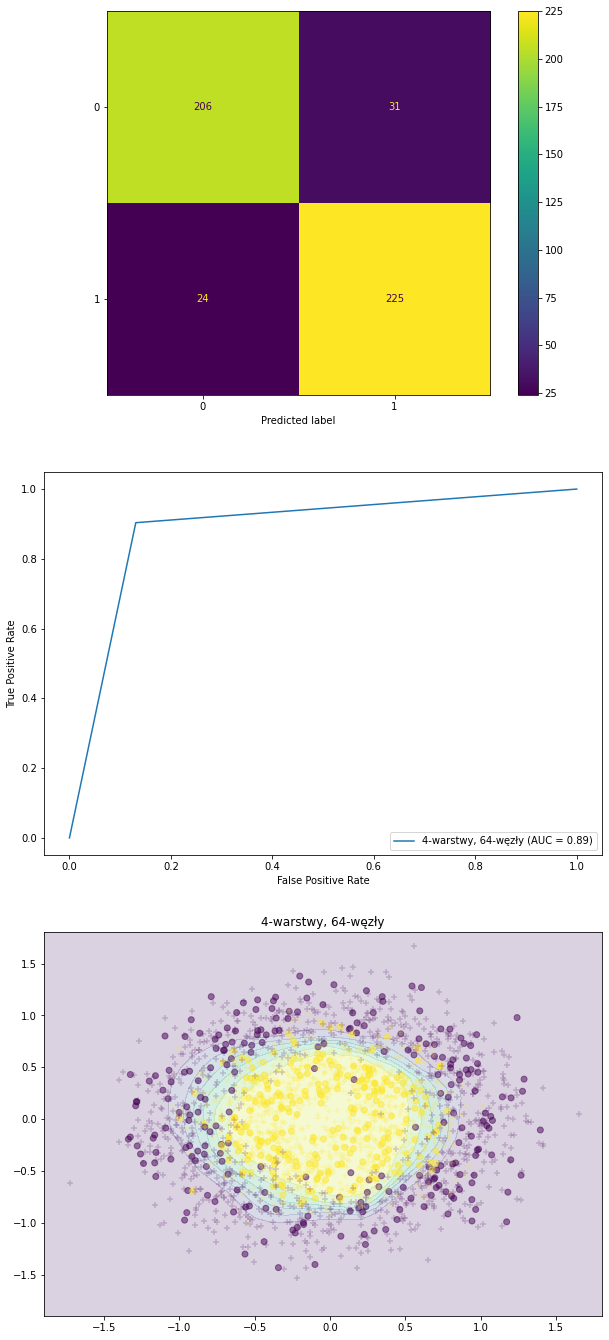

In [13]:
X, y = datasets.make_circles(noise=0.2, factor=0.5, n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network(100)
net.add(FCLayer(2, 64))
net.add(ActivationLayer())
net.add(FCLayer(64, 64))
net.add(ActivationLayer())
net.add(FCLayer(64, 64))
net.add(ActivationLayer())
net.add(FCLayer(64, 1))
net.add(ActivationLayer())


X_train_new = X_train.reshape(X_train.shape[0],1,2)

visualization(net ,X_train_new,X_train, X_test, y_train, y_test,100, 0.3, name = '4-warstwy, 64-węzły')